In [1]:
import time
import sys

sys.path.append('/home/cjw/Code/Unet')
#sys.path.append('/media/cjw/PythonLib/Unet')
from skimage.io import imread
from skimage.transform import resize
from matplotlib import pyplot as plt
import numpy as np
from scipy.ndimage.morphology import distance_transform_edt
import unet2d

%matplotlib inline

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import tensorflow as tf

In [3]:
params = dict()

params['width'] = 256
params['height'] = 256
params['nchannels'] = 3
params['channels'] = [0,1,2]
params['nepochs'] = [1]
params['batchsize'] = [512]
params['learning_rate'] = 0.001
params['restore'] = False
params['latent_size'] = 1
params['enc_sizes'] = [[12,5, 2], [24, 3, 2],
                       [48, 3, 2], [96, 3, 2], [192, 3, 2]]

params['dec_sizes'] = [[96,3, 2], [48, 3, 2],
                       [24, 3, 2], [12, 5, 2], [params['nchannels'] + 2, 3, 2]]
params['droprate'] = 0.1
params['stdev'] = 0.04

In [4]:
## read in the data
data_tif = imread('/ssd1/cjw/Data/sez/NDExp.tif')
labels_tif = imread('/ssd1/cjw/Data/sez/NDExp_labels.tif')
labels_tif = np.moveaxis(labels_tif, 1, -1)

#create the background channel for the labels
temp = np.zeros(labels_tif.shape[0:3] + (3,), dtype=np.float32)
temp[:,:, :, [0,1]] = labels_tif
tsum = labels_tif.max() - labels_tif.max(axis=(-1))
temp[:,:,:, -1] = tsum
labels_tif = temp

#normalize images 0-1
dmin = data_tif.min(axis=(1,2),keepdims=True)
dmax = data_tif.max(axis=(1,2),keepdims=True)
data = (data_tif - dmin)/(dmax - dmin)
labels = (labels_tif - labels_tif.min())/(labels_tif.max() - labels_tif.min())

data_tif.shape, data.shape, labels.shape

((7, 512, 512, 3), (7, 512, 512, 3), (7, 512, 512, 3))

(3, 512, 512) float32 float32


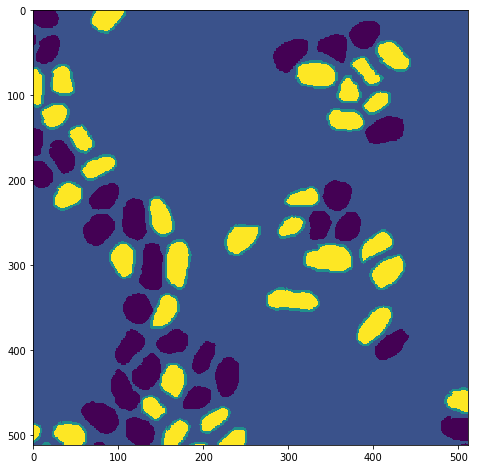

In [5]:

def get_outline(a, ch):
    
    b = a[:,:,ch] 
    b[np.where(b > 0)] = 1
    
    e0 = distance_transform_edt(b)
    ew = np.where(np.logical_and(e0 >= 1, e0 <=3))
    ew0 = np.zeros(b.shape, dtype=a.dtype)
    ew0[ew] = 1
    return ew0, ew

z = labels.copy()

ch4= np.zeros((labels.shape[0:-1] + (2,)), dtype=np.float32)

for i in range(labels.shape[0]):
    ch = 0
    q0, qw0 = get_outline(labels[i], ch)
#     plt.figure(figsize=(4,4))
#     plt.imshow(z[i,:,:,0] + q0)
    z[i,:,:,0][qw0] = 0
    
    ch = 1
    q1, qw1 = get_outline(labels[i], ch)
#     plt.figure(figsize=(4,4))
#     plt.imshow(z[i,:,:,1] + q1)
    z[i,:,:,1][qw1] = 0
    ch4[i,:,:,0] = q0
    ch4[i,:,:,1] = q1

plt.figure(figsize=(8,8))
z = np.concatenate([z, ch4], axis=-1)
labels = z

print(labels[0,:,:,[0,1,3]].shape, ch4.dtype, labels.dtype)
plt.imshow(labels[0,:,:,1] + .5*labels[0,:,:,4] + .25*labels[0,:,:,2])

In [38]:

tf.reset_default_graph()
u = unet2d.unet2d(params)
u.x = data
u.y = labels

In [39]:
w = 256

In [40]:
tf.reset_default_graph()
images = tf.placeholder(tf.float32, (None, w, w, params['nchannels']))
masks = tf.placeholder(tf.float32, (None, w, w, params['nchannels'] + 2))
learning_rate = tf.placeholder(tf.float32, ())
u.learning_rate = learning_rate

In [41]:
enc = u.create_encoder(images, True)

[12, 5, 2] <class 'int'>
[24, 3, 2] <class 'int'>
[48, 3, 2] <class 'int'>
[96, 3, 2] <class 'int'>
[192, 3, 2] <class 'int'>


In [42]:
d = u.create_decoder()
u.create_loss(masks)
u.create_opt()

Tensor("decoder-layer-96/BiasAdd:0", shape=(?, 16, 16, 96), dtype=float32)
4 Tensor("Relu_7:0", shape=(?, 16, 16, 96), dtype=float32)
after concat Tensor("concat-96:0", shape=(?, 16, 16, 192), dtype=float32)
Tensor("Relu_8:0", shape=(?, 16, 16, 96), dtype=float32)
Tensor("decoder-layer-48/BiasAdd:0", shape=(?, 32, 32, 48), dtype=float32)
3 Tensor("Relu_5:0", shape=(?, 32, 32, 48), dtype=float32)
after concat Tensor("concat-48:0", shape=(?, 32, 32, 96), dtype=float32)
Tensor("Relu_9:0", shape=(?, 32, 32, 48), dtype=float32)
Tensor("decoder-layer-24/BiasAdd:0", shape=(?, 64, 64, 24), dtype=float32)
2 Tensor("Relu_3:0", shape=(?, 64, 64, 24), dtype=float32)
after concat Tensor("concat-24:0", shape=(?, 64, 64, 48), dtype=float32)
Tensor("Relu_10:0", shape=(?, 64, 64, 24), dtype=float32)
Tensor("decoder-layer-12/BiasAdd:0", shape=(?, 128, 128, 12), dtype=float32)
1 Tensor("Relu_1:0", shape=(?, 128, 128, 12), dtype=float32)
after concat Tensor("concat-12:0", shape=(?, 128, 128, 24), dtype=fl

In [43]:
#u.set_validation(20)
u.xtrain = u.x

In [44]:
sess = tf.Session()

In [45]:
# tf.summary.scalar('loss', u.loss)
# si = tf.slice(u.decoder, [5, 0, 0, 0, 0], [10,1,256,256, 1])

# si = si[:,:,:,:,0]
# print(si)
# tf.summary.image('res', si, max_outputs=1)    
# merged = tf.summary.merge_all()



# logdir = "logdir"
# logwriter = tf.summary.FileWriter(logdir, sess.graph)

In [46]:
sess.run(tf.global_variables_initializer())

(2, 256, 256, 3) (2, 256, 256, 5)


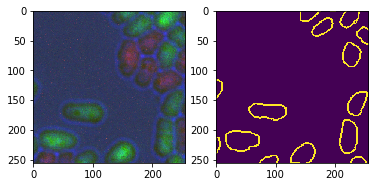

In [47]:
tb, tm = u.get_batch(2, erode=0)
print(tb.shape, tm.shape)
plt.subplot(1,2,1)
plt.imshow(tb[1,:,:,:])
plt.subplot(1,2,2)
plt.imshow(tm[1,:,:,-1])

(256, 256, 5)


(256, 256)

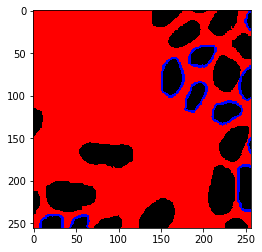

In [48]:
bz = tm[1]
print(bz.shape)
bz[:,:,-2] = 0

bzm = bz.max(axis=-1)
bz[:,:,-1] = 1 - bzm
plt.imshow(bz[:,:,-3:])
bzm.shape

In [49]:
u.stdev = 0.1
#u.learning_rate = 0.0001

0 1.435935 1.435935 0.07260889 0.3863274 0.0009994


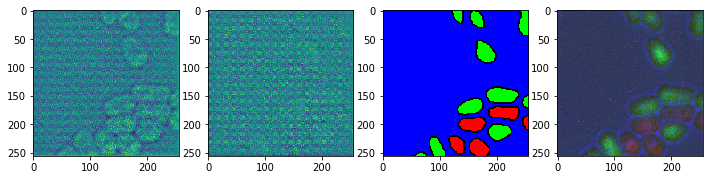

0 1.435935 4.513276100158691 0.0009994
10 0.9289272 2.935809850692749 0.0009934197644027314
20 0.8636152 3.642939805984497 0.000987475313494075
30 0.8057728 3.7620415687561035 0.0009815664331446845
40 0.7833177 3.7844464778900146 0.0009756929105065258
50 0.77629185 2.933164119720459 0.0009698545340052114
60 0.72785795 3.0032615661621094 0.0009640510933323775
70 0.6867139 4.172531843185425 0.0009582823794381092
80 0.658785 4.2001917362213135 0.0009525481845234097
90 0.56062925 4.282792568206787 0.0009468483020327152
100 0.54667497 0.54667497 1.0542726e-06 0.99912983 0.0009411825266464541


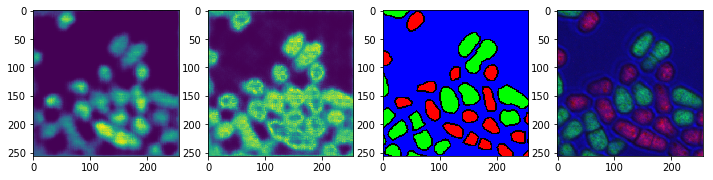

100 0.54667497 3.7177658081054688 0.0009411825266464541
110 0.5055742 4.55345344543457 0.0009355506542736522
120 0.52233064 3.5808513164520264 0.0009299524820445797
130 0.505246 3.707512378692627 0.0009243878083034437
140 0.48409194 5.52820611000061 0.0009188564326011252
150 0.4964813 3.3430442810058594 0.0009133581556879571
160 0.46339035 4.923532247543335 0.0009078927795065476
170 0.45838693 5.117046356201172 0.0009024601071846466
180 0.40810508 5.452775001525879 0.0008970599430280523
190 0.37968212 4.511953353881836 0.0008916920925135638
200 0.38128218 0.38128218 2.8462107e-06 0.9953194 0.0008863563622819725


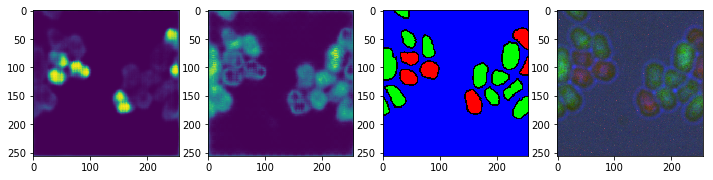

200 0.38128218 4.7720606327056885 0.0008863563622819725
210 0.34679008 3.9967963695526123 0.0008810525601310981
220 0.32279763 4.658015489578247 0.0008757804950088642
230 0.30143723 4.730686902999878 0.0008705399770064175
240 0.30710763 4.401288986206055 0.0008653308173512857
250 0.2921621 4.532835483551025 0.0008601528284005777
260 0.2888791 3.9734275341033936 0.0008550058236342256
270 0.28135246 3.333904981613159 0.000849889617648265
280 0.28477398 3.8285763263702393 0.0008448040261481561
290 0.2856347 4.13670015335083 0.0008397488659421457
300 0.2694582 0.2694582 2.9090096e-17 0.9999999 0.0008347239549346682


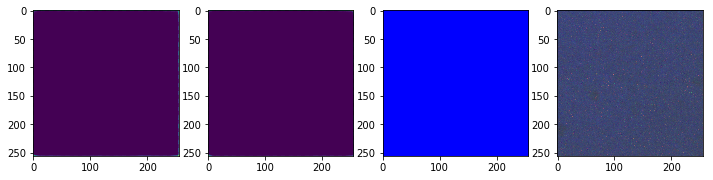

300 0.2694582 3.3377881050109863 0.0008347239549346682
310 0.2649785 4.9142515659332275 0.0008297291121197865
320 0.25535268 3.678896188735962 0.0008247641575746708
330 0.2589906 4.076411962509155 0.0008198289124531189
340 0.259509 5.021729469299316 0.0008149231989791124
350 0.28192478 3.983927011489868 0.0008100468404404146
360 0.26152155 5.045186996459961 0.0008051996611822031
370 0.25632563 4.78549861907959 0.0008003814866007439
380 0.2612331 3.6346707344055176 0.0007955921431371015
390 0.25395572 4.350236415863037 0.0007908314582708864
400 0.25099874 0.25099874 4.9222023e-18 1.0 0.000786099260514041


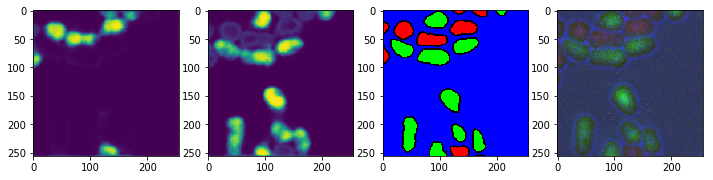

400 0.25099874 4.701074123382568 0.000786099260514041
410 0.2607631 3.6890532970428467 0.0007813953794046629
420 0.2567191 4.599181413650513 0.0007767196455008638
430 0.24748605 4.5485429763793945 0.0007720718903746664
440 0.23965397 4.128212213516235 0.0007674519466059365
450 0.2576353 4.287398099899292 0.0007628596477763529
460 0.24270198 4.347394943237305 0.0007582948284634136
470 0.24202853 4.403295993804932 0.0007537573242344746
480 0.24946046 3.3388233184814453 0.0007492469716408296
490 0.244394 5.000397682189941 0.0007447636082118204
500 0.24680914 0.24680914 9.4909645e-21 1.0 0.0007403070724489843


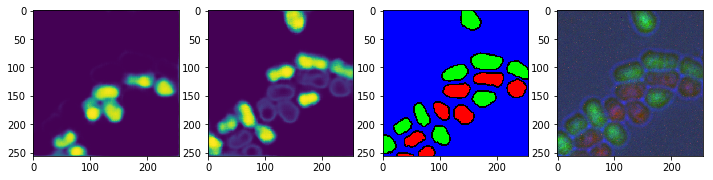

500 0.24680914 4.752867937088013 0.0007403070724489843
510 0.22683258 3.783322811126709 0.0007358772038202383
520 0.24035515 3.90055775642395 0.0007314738427540945
530 0.2522354 4.5310914516448975 0.0007270968306339136
540 0.23915909 4.175781011581421 0.0007227460097921905
550 0.24394819 4.5081799030303955 0.0007184212235048752
560 0.23882914 3.524099588394165 0.0007141223159857265
570 0.25291917 4.385417699813843 0.0007098491323807021
580 0.22365879 3.3199141025543213 0.0007056015187623779
590 0.23902868 4.031196355819702 0.0007013793221244058
600 0.25277725 0.25277725 9.938767e-24 0.9998203 0.0006971823903760004


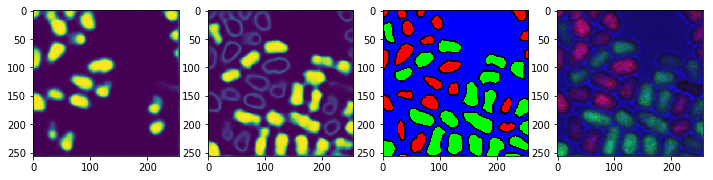

600 0.25277725 3.711914539337158 0.0006971823903760004
610 0.2294151 4.312677621841431 0.0006930105723364615
620 0.24641818 4.139712333679199 0.0006888637177297275
630 0.23408784 4.102266788482666 0.0006847416771789632
640 0.23399383 4.5481390953063965 0.0006806443022011777
650 0.23118006 4.5539634227752686 0.0006765714452018768
660 0.22664516 4.714175224304199 0.000672522959469746
670 0.23139626 4.017156600952148 0.0006684986991713657
680 0.23987213 4.210905313491821 0.0006644985193459582
690 0.24787052 4.047247648239136 0.000660522275900166
700 0.2513564 0.2513564 1.8093807e-22 0.99990463 0.0006565698256028606


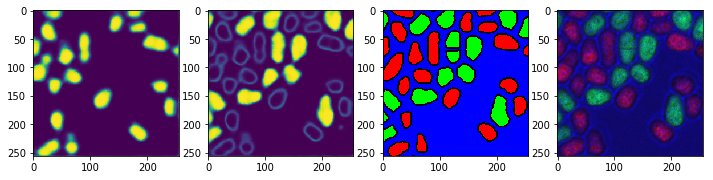

700 0.2513564 4.448211431503296 0.0006565698256028606
710 0.22031784 4.009520530700684 0.0006526410260799844
720 0.22774106 4.4491071701049805 0.0006487357358094207
730 0.23098028 4.055051565170288 0.000644853814115897
740 0.22056742 3.640085458755493 0.0006409951211659168
750 0.22374453 4.300799131393433 0.0006371595179627234
760 0.23481135 3.8329622745513916 0.0006333468663412915
770 0.22478354 3.802443027496338 0.0006295570289633521
780 0.22772804 3.9659056663513184 0.0006257898693124444
790 0.22112668 3.705859899520874 0.0006220452516889981
800 0.21447982 0.21447982 5.8495903e-17 1.0 0.0006183230412054457


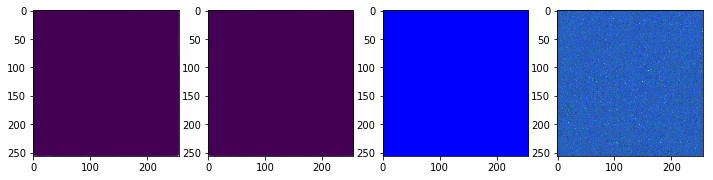

800 0.21447982 4.656997442245483 0.0006183230412054457
810 0.2302952 4.079222679138184 0.0006146231037813632
820 0.20964375 4.313525676727295 0.0006109453061386408
830 0.22301057 4.161314964294434 0.0006072895157966814
840 0.24266376 4.076390981674194 0.0006036556010676288
850 0.22220561 3.8815231323242188 0.0006000434310516241
860 0.2189644 3.979912757873535 0.0005964528756320904
870 0.23026337 4.719155788421631 0.0005928838054710459
880 0.23455994 3.8648054599761963 0.0005893360920044441
890 0.22486831 3.9654436111450195 0.000585809607437544
900 0.22296107 0.22296107 0.0 1.0 0.0005823042247403059


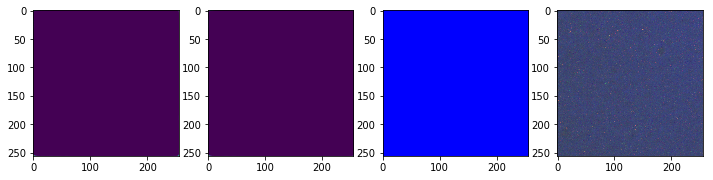

900 0.22296107 5.1107611656188965 0.0005823042247403059
910 0.22252001 4.210350036621094 0.0005788198176428155
920 0.21308991 3.8719754219055176 0.0005753562606307365
930 0.22251227 4.523753881454468 0.0005719134289407874
940 0.21390584 3.551280975341797 0.0005684911985562489
950 0.20719811 3.8507864475250244 0.0005650894462024967
960 0.21550496 4.179396390914917 0.0005617080493425597
970 0.2159941 4.369217872619629 0.0005583468861727073
980 0.21968064 3.805910110473633 0.0005550058356180605
990 0.21235546 4.047074556350708 0.0005516847773282318
1000 0.21772763 0.21772763 7.819372e-18 0.99999726 0.0005483835916729894


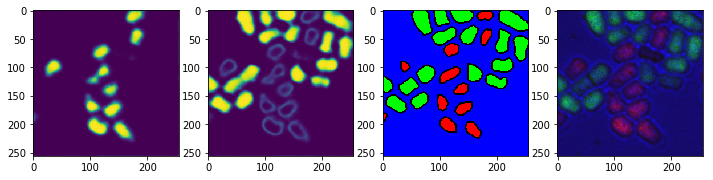

1000 0.21772763 4.491525173187256 0.0005483835916729894
1010 0.22685006 4.222936630249023 0.0005451021597379478
1020 0.21044695 3.243168592453003 0.0005418403633202845
1030 0.20191029 3.419923782348633 0.000538598084924482
1040 0.21250845 3.920879602432251 0.0005353752077580961
1050 0.22094744 4.227938890457153 0.000532171615727548
1060 0.21707514 3.315399169921875 0.0005289871934339421
1070 0.22788972 4.278931617736816 0.0005258218261689104
1080 0.21727057 4.843332052230835 0.0005226753999104793
1090 0.21602559 4.6513988971710205 0.0005195478013189634
1100 0.21720104 0.21720104 1.0210044e-21 0.99999905 0.0005164389177328815


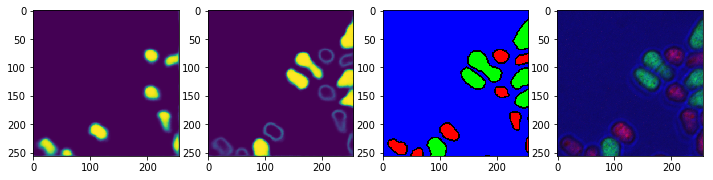

1100 0.21720104 4.90812349319458 0.0005164389177328815
1110 0.20771189 3.5347020626068115 0.0005133486371648997
1120 0.20376417 4.245415687561035 0.0005102768482977965
1130 0.20944595 4.358794927597046 0.0005072234404804537
1140 0.22468051 3.9551444053649902 0.0005041883037238695
1150 0.21084017 4.142328977584839 0.0005011713286971975
1160 0.210082 3.5286753177642822 0.0004981724067238082
1170 0.21753822 4.5313005447387695 0.0004951914297773738
1180 0.19889955 4.000399112701416 0.0004922282904779772
1190 0.20807824 4.354981184005737 0.0004892828820882444
1200 0.20548594 0.20548594 8.2522883e-19 1.0 0.000486355098509499


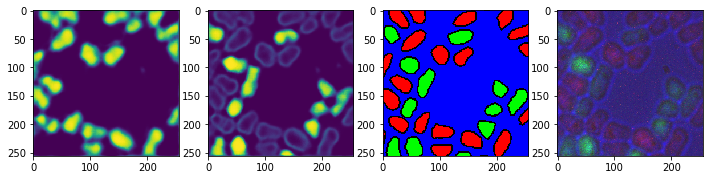

1200 0.20548594 4.557925462722778 0.000486355098509499
1210 0.20798072 3.495227098464966 0.0004834448342779406
1220 0.21173677 4.608423948287964 0.00048055198456084584
1230 0.20567784 4.9068944454193115 0.0004776764451527923
1240 0.21022655 3.329320192337036 0.00047481811247190446
1250 0.2039574 3.507589817047119 0.0004719768835561227
1260 0.20954318 4.868952512741089 0.00046915265605949473
1270 0.20478185 4.0421388149261475 0.0004663453282484881
1280 0.20876743 3.356901168823242 0.0004635547989983266
1290 0.20452112 4.414451837539673 0.00046078096778934686
1300 0.2182622 0.2182622 6.748921e-22 0.9999906 0.0004580237347033776


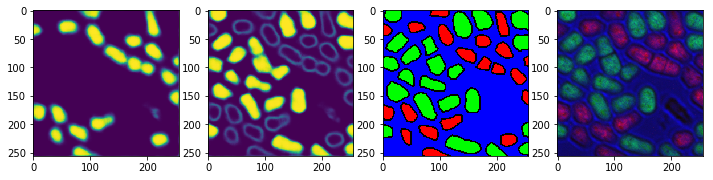

1300 0.2182622 3.868171215057373 0.0004580237347033776
1310 0.2076253 4.092529058456421 0.0004552830004201408
1320 0.20356373 4.467548608779907 0.0004525586662136733
1330 0.20362128 3.5321409702301025 0.00044985063394877115
1340 0.19761828 4.202763557434082 0.00044715880607745415
1350 0.20406488 4.302763223648071 0.0004444830856354526
1360 0.198477 4.1312575340271 0.0004418233762387137
1370 0.20227207 4.456425428390503 0.0004391795820799304
1380 0.19927555 4.315594434738159 0.0004365516079250896
1390 0.20890555 4.307583570480347 0.0004339393591100422
1400 0.20777333 0.20777333 0.0 1.0 0.00043134274153709283


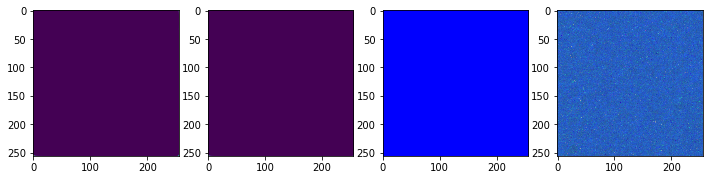

1400 0.20777333 5.390565395355225 0.00043134274153709283
1410 0.2169399 4.157276630401611 0.00042876166167161
1420 0.20959426 3.62990403175354 0.0004261960265386577
1430 0.19714013 4.349641799926758 0.0004236457437196455
1440 0.19888824 3.2846672534942627 0.0004211107213489997
1450 0.1980229 4.633281946182251 0.00041859086811085424
1460 0.20060769 4.207207918167114 0.0004160860932357612
1470 0.18680914 4.197049140930176 0.0004135963064974214
1480 0.19959892 4.328267812728882 0.000411121418209434
1490 0.20101634 3.223334550857544 0.0004086613392220661
1500 0.19413036 0.19413036 0.0 1.0 0.00040621598091904117


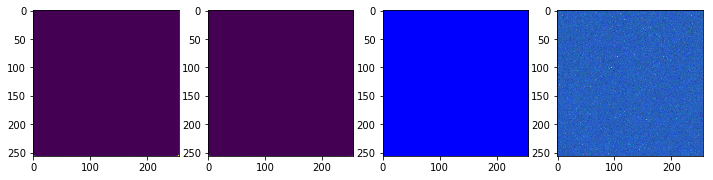

1500 0.19413036 4.8918046951293945 0.00040621598091904117
1510 0.20288686 4.7295918464660645 0.0004037852552143471
1520 0.2076234 4.402705192565918 0.00040136907454906305
1530 0.18871906 4.994466304779053 0.0003989673518882056
1540 0.1962766 4.686464309692383 0.0003965800007175936
1550 0.19358434 3.994436025619507 0.0003942069350407314
1560 0.20610636 3.8107471466064453 0.00039184806937571175
1570 0.19842751 3.892305612564087 0.0003895033187521362
1580 0.19468597 4.574542045593262 0.0003871725987080541
1590 0.20068233 3.5708370208740234 0.00038485582528692064
1600 0.2048817 0.2048817 0.0 1.0 0.00038255291503457223


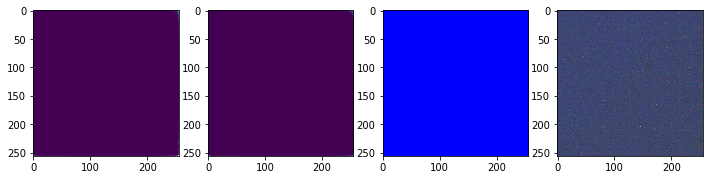

1600 0.2048817 3.9134559631347656 0.00038255291503457223
1610 0.18320173 4.029958486557007 0.0003802637849962207
1620 0.19974506 4.198173522949219 0.00037798835271346456
1630 0.19305544 3.2888262271881104 0.0003757265362213194
1640 0.19363758 4.394582033157349 0.0003734782540452647
1650 0.18381257 4.165592432022095 0.00037124342519830945
1660 0.19099514 3.7775444984436035 0.0003690219691780746
1670 0.19778797 4.391245603561401 0.00036681380596389335
1680 0.20340239 4.4375574588775635 0.0003646188560139286
1690 0.19441962 4.12893009185791 0.0003624370402623079
1700 0.18565606 0.18565606 7.312111e-21 0.99999964 0.000360268280116275


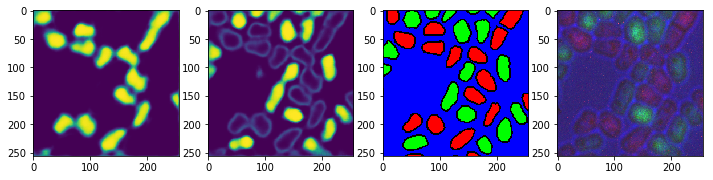

1700 0.18565606 4.485622406005859 0.000360268280116275
1710 0.20088124 4.272250413894653 0.0003581124974533592
1720 0.20888257 4.395534038543701 0.0003559696146185612
1730 0.20270945 4.263069152832031 0.00035383955442155516
1740 0.19265772 3.8509161472320557 0.0003517222401339092
1750 0.18641095 3.4299044609069824 0.00034961759548632083
1760 0.17744844 3.906160593032837 0.00034752554466586986
1770 0.18612325 3.7650856971740723 0.0003454460123132874
1780 0.18803346 3.6834516525268555 0.0003433789235202413
1790 0.18797511 3.5962424278259277 0.00034132420382663775
1800 0.18711044 0.18711044 0.0 1.0 0.0003392817792179392


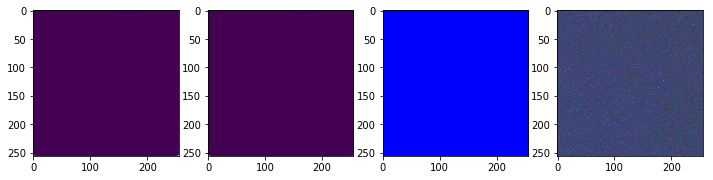

1800 0.18711044 4.203964948654175 0.0003392817792179392
1810 0.19132759 4.443870544433594 0.00033725157612249823
1820 0.19298565 4.952730417251587 0.0003352335214089074
1830 0.18919739 4.196123838424683 0.00033322754238336496
1840 0.19311504 4.116435766220093 0.000331233566787056
1850 0.18044278 4.2561352252960205 0.0003292515227935498
1860 0.18401366 4.03141188621521 0.0003272813390062126
1870 0.1829884 4.225990295410156 0.0003253229444556357
1880 0.18739042 3.7511215209960938 0.0003233762685970787
1890 0.19162256 3.2585222721099854 0.00032144124130792926
1900 0.18736295 0.18736295 0.0 1.0 0.00031951779288517577


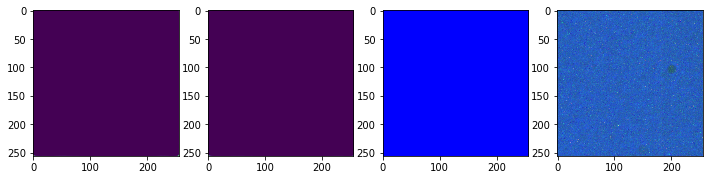

1900 0.18736295 4.5790345668792725 0.00031951779288517577
1910 0.18141915 4.527837514877319 0.0003176058540428979
1920 0.19455788 3.9399847984313965 0.0003157053559097698
1930 0.18912427 5.0738205909729 0.00031381623002658005
1940 0.17796348 4.431028366088867 0.00031193840834376494
1950 0.1798982 3.950044631958008 0.0003100718232189574
1960 0.1785295 3.7777042388916016 0.00030821640741455087
1970 0.18516597 3.3295693397521973 0.0003063720940952766
1980 0.17667812 3.5827219486236572 0.0003045388168257968
1990 0.18174842 3.549527168273926 0.0003027165095683106
2000 0.18077804 0.18077804 0.0 1.0 0.0003009051066801765


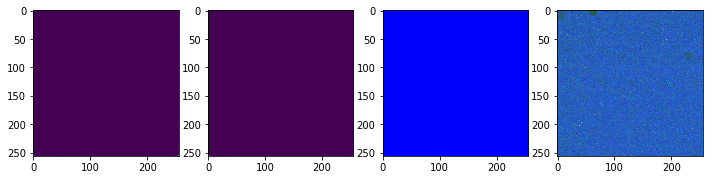

2000 0.18077804 4.163942575454712 0.0003009051066801765
2010 0.18524474 4.78656792640686 0.0002991045429115467
2020 0.17639807 3.334350824356079 0.00029731475340301724
2030 0.19197151 4.188772439956665 0.0002955356736832916
2040 0.18381764 3.548274517059326 0.0002937672396668582
2050 0.17720582 3.2714431285858154 0.0002920093876516821
2060 0.18008485 3.4384536743164062 0.00029026205431691013
2070 0.19305067 3.4755659103393555 0.0002885251767205902
2080 0.17388363 4.678910732269287 0.00028679869229740365
2090 0.17779106 4.31288743019104 0.0002850825388564121
2100 0.18724558 0.18724558 7.3401424e-26 1.0 0.0002833766545788168


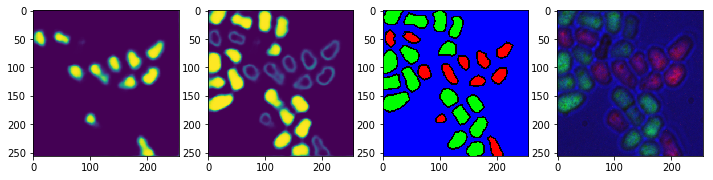

2100 0.18724558 4.973462820053101 0.0002833766545788168
2110 0.1706481 4.266011953353882 0.00028168097801573196
2120 0.1724659 4.3163862228393555 0.00027999544808597106
2130 0.16774073 4.578932285308838 0.00027832000407384703
2140 0.17464536 3.2315967082977295 0.00027665458562698466
2150 0.18254517 4.7300615310668945 0.000274999132754147
2160 0.16644895 3.9509358406066895 0.000273353585823074
2170 0.17706323 5.115495920181274 0.0002717178855583351
2180 0.17892548 4.12935996055603 0.00027009197303919325
2190 0.17887132 4.338976621627808 0.0002684757896974828
2200 0.17762361 0.17762361 6.924342e-23 1.0 0.0002668692773155


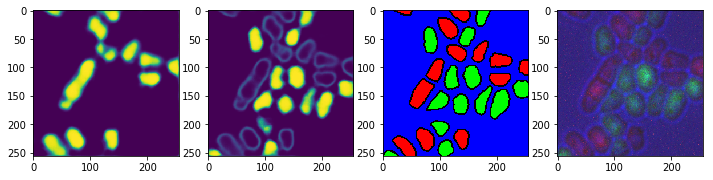

2200 0.17762361 4.611003398895264 0.0002668692773155
2210 0.17341097 3.9640305042266846 0.00026527237802390557
2220 0.17993383 4.358403205871582 0.0002636850342996404
2230 0.17585894 4.303116798400879 0.0002621071889638532
2240 0.16893423 4.952101230621338 0.0002605387851798412
2250 0.17819032 4.284637451171875 0.00025897976645100233
2260 0.18047333 4.304280996322632 0.00025743007661880045
2270 0.17563796 4.082505702972412 0.0002558896598607423
2280 0.16602713 3.919884204864502 0.00025435846068836673
2290 0.17151466 4.463757753372192 0.00025283642394524587
2300 0.17928077 0.17928077 7.2700335e-27 0.9999999 0.00025132349480499837


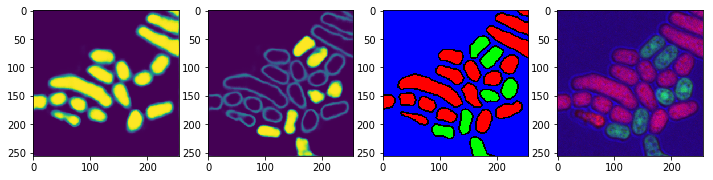

2300 0.17928077 3.624910354614258 0.00025132349480499837
2310 0.17737609 3.3912124633789062 0.0002498196187693142
2320 0.17614311 3.5603604316711426 0.000248324741665992
2330 0.16438508 4.365279912948608 0.0002468388096469872
2340 0.17759424 5.129692316055298 0.00024536176918647264
2350 0.16548878 4.281411647796631 0.00024389356707891049
2360 0.17266625 3.8305270671844482 0.00024243415043713538
2370 0.17084953 4.259430885314941 0.00024098346669044964
2380 0.17740697 4.404128074645996 0.0002395414635827297
2390 0.17222174 4.21418833732605 0.00023810808917054324
2400 0.16506517 0.16506517 0.0 1.0 0.00023668329182127847


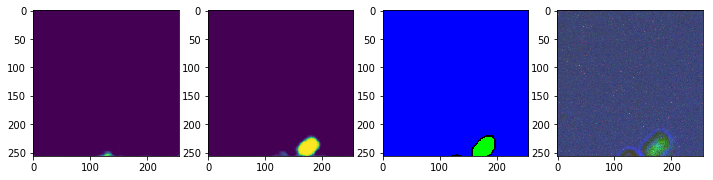

2400 0.16506517 4.190868139266968 0.00023668329182127847
2410 0.15744075 3.757786750793457 0.0002352670202112842
2420 0.16795276 3.9940927028656006 0.00023385922332402109
2430 0.17471972 4.254231691360474 0.00023245985044822377
2440 0.16657871 4.266862869262695 0.00023106885117607436
2450 0.16150701 4.284933805465698 0.00022968617540138647
2460 0.16122429 4.274139881134033 0.0002283117733178005
2470 0.17379224 3.5917506217956543 0.0002269455954169895
2480 0.16826314 3.7688257694244385 0.0002255875924868755
2490 0.16700764 4.479892253875732 0.00022423771560985722
2500 0.17258301 0.17258301 6.671445e-28 1.0 0.00022289591616104774


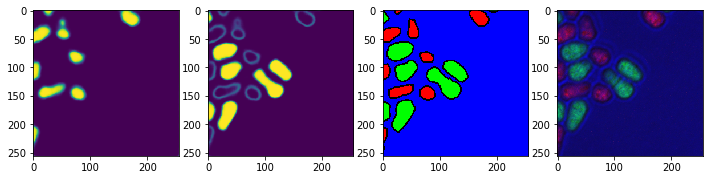

2500 0.17258301 4.762191295623779 0.00022289591616104774
2510 0.16647801 4.333876609802246 0.000221562145806523
2520 0.16396978 3.3702244758605957 0.0002202363565015807
2530 0.17486551 4.29115891456604 0.0002189185004890097
2540 0.17158197 4.021371364593506 0.00021760853029736979
2550 0.16660927 4.262217044830322 0.00021630639873928135
2560 0.16886051 4.207056283950806 0.00021501205890972605
2570 0.15267316 4.085350513458252 0.00021372546418435694
2580 0.16501969 4.720729351043701 0.00021244656821781905
2590 0.16681571 4.129884958267212 0.00021117532494207989
2600 0.16652866 0.16652866 5.6406493e-30 1.0 0.00020991168856477016


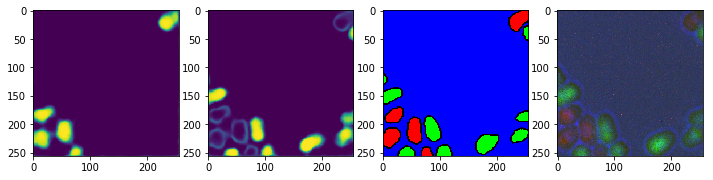

2600 0.16652866 4.671621322631836 0.00020991168856477016
2610 0.17035155 4.280565023422241 0.00020865561356753407
2620 0.17359984 4.8374927043914795 0.00020740705470438973
2630 0.17553435 5.005046367645264 0.00020616596700009934
2640 0.16842951 3.7032759189605713 0.00020493230574854915
2650 0.17262729 3.34451961517334 0.00020370602651113894
2660 0.15887643 3.485828161239624 0.00020248708511518134
2670 0.16243607 4.287286281585693 0.00020127543765231069
2680 0.17466007 3.868300676345825 0.00020007104047690133
2690 0.161907 4.194967031478882 0.00019887385020449542
2700 0.15756488 0.15756488 0.0 1.0 0.00019768382371024016


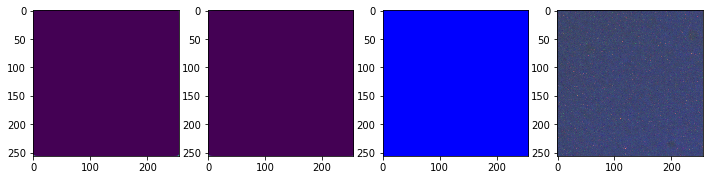

2700 0.15756488 4.2674643993377686 0.00019768382371024016
2710 0.15641814 4.333056688308716 0.0001965009181273343
2720 0.16251305 4.074737071990967 0.00019532509084548418
2730 0.16386093 4.486972808837891 0.00019415629950936866
2740 0.15740779 3.187075614929199 0.00019299450201711344
2750 0.16406897 4.342585802078247 0.0001918396565187746
2760 0.15346399 4.185926198959351 0.00019069172141483092
2770 0.16349527 3.3727874755859375 0.00018955065535468542
2780 0.17191085 4.366036891937256 0.00018841641723517608
2790 0.16070291 3.329918146133423 0.00018728896619909488
2800 0.1657671 0.1657671 0.0 1.0 0.00018616826163371617


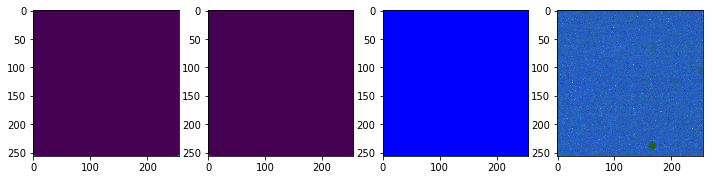

2800 0.1657671 3.806443214416504 0.00018616826163371617
2810 0.1610582 4.751279592514038 0.00018505426316933402
2820 0.16045414 3.6782264709472656 0.0001839469306778076
2830 0.16720217 3.253483772277832 0.00018284622427111588
2840 0.15567674 4.408339738845825 0.00018175210429992092
2850 0.16346517 4.892616510391235 0.00018066453135213943
2860 0.16094165 4.147695064544678 0.00017958346625152318
2870 0.16391131 3.5821075439453125 0.00017850887005624785
2880 0.14862487 4.378968715667725 0.00017744070405751008
2890 0.16519141 3.932009220123291 0.00017637892977813335
2900 0.15440744 0.15440744 7.0195604e-31 0.99999905 0.0001753235089711819


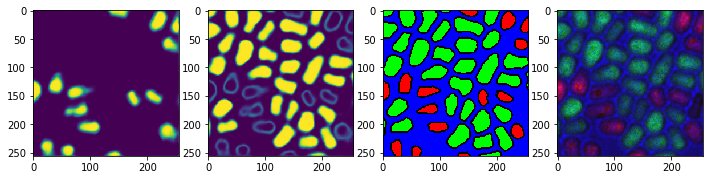

2900 0.15440744 4.3656005859375 0.0001753235089711819
2910 0.16307747 4.06005072593689 0.00017427440361858287
2920 0.15663323 3.6546630859375 0.000173231575929757
2930 0.1548598 4.368013143539429 0.00017219498834025726
2940 0.15853558 5.118764162063599 0.00017116460351041573
2950 0.16070968 4.76585578918457 0.00017014038432399856
2960 0.15524828 3.811707019805908 0.00016912229388686898
2970 0.15605946 4.155115127563477 0.0001681102955256583
2980 0.15867455 3.674501895904541 0.00016710435278644495
2990 0.16148809 4.261422395706177 0.00016610442943344118


In [50]:


rate = 0.001
#loss_file = open('progress.dat', 'w', buffering=1)
for i in range(3000):
    t1 = time.time()
    rate = np.maximum(rate*.9994, 0.000005)
    bx, bm = u.get_batch(512, erode=0)
#     plt.figure(figsize=(2,2))
#     plt.imshow(bm[0])
    _, res, err = sess.run([u.opt, u.decoder_softmax, u.loss],
                           feed_dict={images:bx, masks:bm, learning_rate:rate})
    if i % 100 == 0:
        print(i, err, err, res[0,:,:,:].min(), res[0,:,:,:].max(), rate)
        nr = np.random.randint(0,1)
        plt.figure(figsize=(12,4))
        plt.subplot(1,4,1)
        plt.imshow(res[nr,:,:,0] + .5*res[nr,:,:,3])
        plt.subplot(1,4,2)
        plt.imshow(res[nr,:,:,1] + .5*res[nr,:,:,3])
        plt.subplot(1,4,3)
        plt.imshow(bm[nr,:,:,0:3])
        plt.subplot(1,4,4)
        plt.imshow(bx[nr,:,:,:])
        
#         plt.subplot(1,6,4)
#         plt.imshow(res[nr,:,:,1])
#         plt.subplot(1,6,5)
#         plt.imshow(bm[nr,:,:,1])
#         plt.subplot(1,6,6)
#         plt.imshow(bx[nr,:,:,1])
        plt.show()
        #plt.savefig("images/image{0:05d}".format(i))
    t2 = time.time()
    if i % 10 == 0:
        print(i, err, (t2 - t1), rate)


(512, 256, 256, 5)


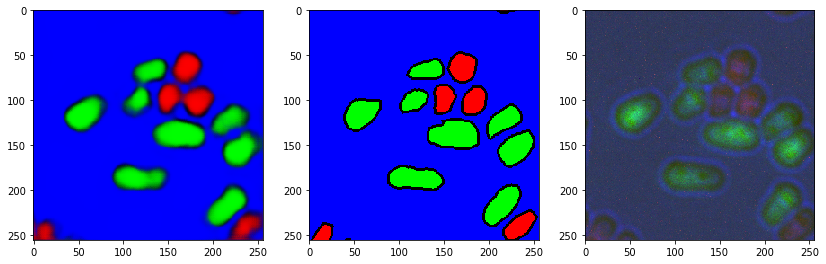

In [65]:
na = 4
plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
print(bm.shape)
plt.imshow(res[na,:,:,0:3])
plt.subplot(1,3,2)
plt.imshow(bm[na,:,:,0:3])
plt.subplot(1,3,3)
plt.imshow(bx[na,:,:,:])


In [26]:
plt.hist(res[na,:,:,:].reshape((-1,3)))

ValueError: cannot reshape array of size 65536 into shape (3)

In [90]:
#test_tif = imread('/ssd1/cjw/Data/sez/RawTifs/10_hours_punched_overnight/NDExp_Point0017_Seq0017.tif')
test_tif = imread('/ssd1/cjw/Data/sez/RawTifs/NDExp_Point0004_Seq0004.tif')
ymax = test_tif.max(axis=(0,1), keepdims=True)
ymin = test_tif.min(axis=(0,1), keepdims=True)

test_tif = (test_tif - ymin)/(ymax - ymin + 0.00001)

test_tif.shape, ymin.shape

((2044, 2048, 3), (1, 1, 3))

In [91]:
def make_batch(data, start = 0):
    tclist = list()
    print(start)
    ix = start
    jy = start
    for i in range(6):
        jy = start
        for j in range(6):
            p = data[jy:jy + 256, ix:ix + 256,:]
            p = np.expand_dims(p, 0)
            tclist.append(p)
            jy = jy + 256
            #print(i, j, ix, jy)
        ix += 256

    tc = np.concatenate(tclist, axis=0)
    return tc

tc0 = make_batch(test_tif,start=0)
tc1 = make_batch(test_tif, start=128)
tc0.shape, tc1.shape

0
128


((36, 256, 256, 3), (36, 256, 256, 3))

In [92]:
vres0 = sess.run(u.decoder_softmax,
                feed_dict={images:tc0})

vres1 = sess.run(u.decoder_softmax,
                feed_dict={images:tc1})
vres0.shape, vres1.shape

((36, 256, 256, 5), (36, 256, 256, 5))

In [93]:
def reconstruct(v1, w, nx, ny, offset=0, pad=0):
    p = np.zeros((ny*w + pad, nx*w + pad, 5), dtype=np.float32)

    ix = offset
    jy = offset
    index = 0
    for i in range(nx):
        jy = offset
        for j in range(ny):
            p[jy:jy + 256, ix:ix + 256, :] = v1[index]
            jy = jy + 256
            index += 1
            #print(i, j, ix, jy)
        ix += 256
    return p
r0 = reconstruct(vres0, 256, 6, 6, offset=0, pad=128)
r1 = reconstruct(vres1, 256, 6, 6, offset=128, pad = 128)

r0 = np.expand_dims(r0, 0)
r1 = np.expand_dims(r1, 0)
r = np.concatenate([r0, r1])
r  = r.max(axis=(0))
r.shape, r.max()

((1664, 1664, 5), 1.0)

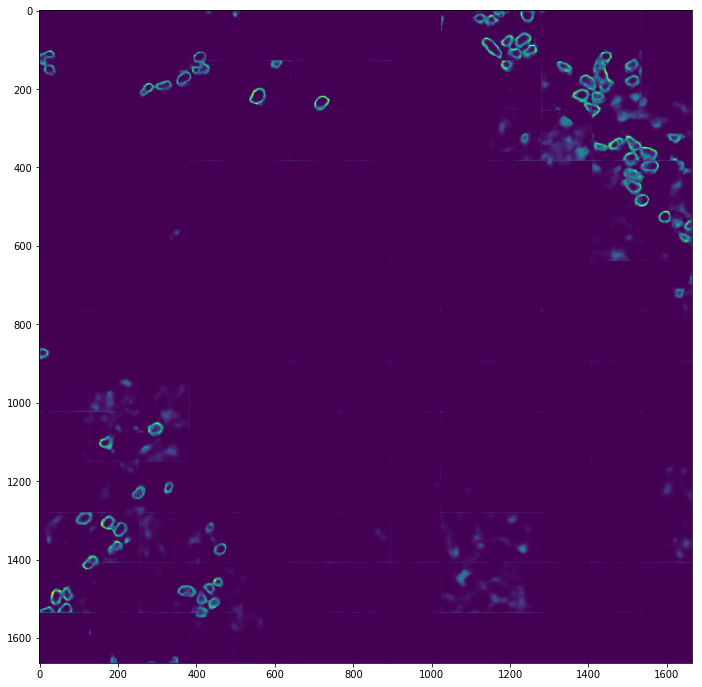

In [101]:

plt.figure(figsize=(12,12))

# az = r*0
# az[:,:,0] = r[:,:,-1]
# az[:,:,1] = r[:,:,-1]
# az[:,:,2] = r[:,:,-1]
# az = r - az

#plt.subplot(1,3,1)
plt.imshow(r[:,:,4]) #0[0,150:350,100:300,1])

#plt.subplot(1,3,4)
#plt.imshow(r0[0]) #[0,150:350,100:300,1])

#plt.subplot(1,3,3)
#plt.imshow(r1[0]) #[150:350,100:300,1])

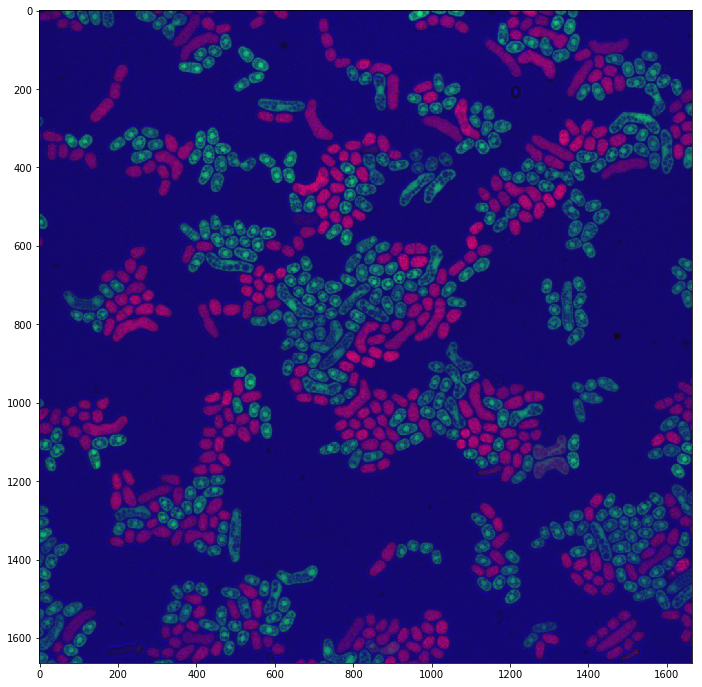

In [87]:
plt.figure(figsize=(12,12))
plt.imshow(test_tif[0:6*256+128, 0:6*256+128, :])

In [88]:
import tifffile
r.shape

(1664, 1664, 5)

In [89]:
tifffile.imsave('/ssd1/cjw/Data/sez/unetout0017.tif', np.moveaxis(r, -1, 0))

In [ ]:
from skimage.morphology import binary_erosion

blab = labels[2, :,:,1]
plt.subplot(1,2,1)
plt.imshow(blab)
plt.subplot(1,2,2)
plt.imshow(binary_erosion(binary_erosion(blab)))
labels.shape

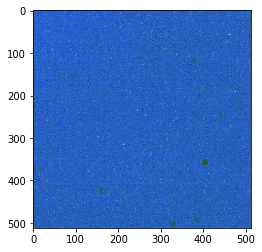

In [102]:
plt.imshow(data[6,:,:,0:3])

In [104]:
!%mkdir '/ssd1/cjw/sez/unet_checkpoint'

/bin/sh: 1: %mkdir: not found


In [105]:
saver = tf.train.Saver()
saver.save(sess, '/ssd1/cjw/sez/unet_checkpoint', global_step=3000)

'/ssd1/cjw/sez/unet_checkpoint-3000'